In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [7]:
# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

In [8]:
# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-06-12   AAPL  182.819092  183.789993  183.889999  180.970001   
1         2023-06-12   GOOG  124.208656  124.349998  124.750000  122.349998   
2         2023-06-12   MSFT  329.274200  331.850006  332.100006  325.160004   
3         2023-06-12   NFLX  423.970001  423.970001  424.700012  416.570007   
4         2023-06-12   TSLA  249.830002  249.830002  250.970001  244.589996   

Attribute        Open       Volume  
0          181.270004   54274900.0  
1          123.394997   22255700.0  
2          328.579987   24260300.0  
3          418.829987    5959500.0  
4          247.940002  150337900.0  


In [9]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-06-12   AAPL  182.819092  183.789993  183.889999  180.970001  181.270004   
2023-06-12   GOOG  124.208656  124.349998  124.750000  122.349998  123.394997   
2023-06-12   MSFT  329.274200  331.850006  332.100006  325.160004  328.579987   
2023-06-12   NFLX  423.970001  423.970001  424.700012  416.570007  418.829987   
2023-06-12   TSLA  249.830002  249.830002  250.970001  244.589996  247.940002   

Attribute        Volume  
Date                     
2023-06-12   54274900.0  
2023-06-12   22255700.0  
2023-06-12   24260300.0  
2023-06-12    5959500.0  
2023-06-12  150337900.0  


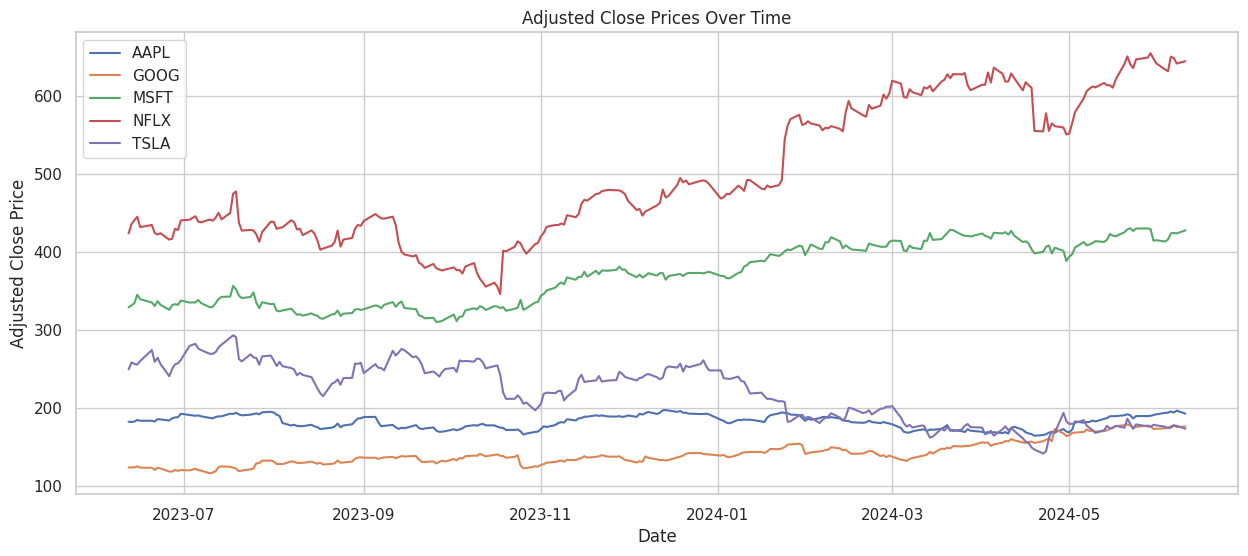

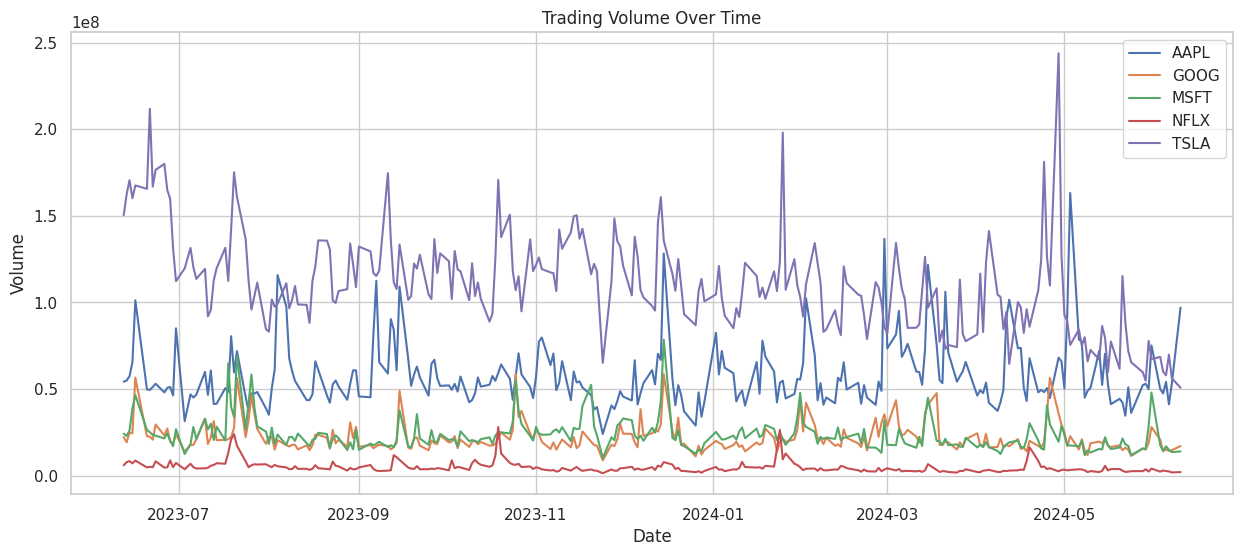

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [11]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2024-04-19   AAPL  164.776505  165.000000  166.399994  164.080002  166.210007   
2024-04-26   GOOG  173.492569  173.690002  176.419998  171.399994  175.990005   
2024-05-07   GOOG  172.783371  172.979996  173.470001  170.000000  170.119995   
2024-05-15   GOOG  173.682358  173.880005  174.046005  172.029999  172.300003   
2024-05-16   GOOG  175.230591  175.429993  176.339996  174.050003  174.600006   

Attribute       Volume   Z-score  
Date                              
2024-04-19  67772100.0 -2.033084  
2024-04-26  56500800.0  2.079093  
2024-05-07  21102400.0  2.032593  
2024-05-15  20958200.0  2.091537  
2024-05-16  17247300.0  2.193051  


In [12]:
print(anomalies_volume.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-06-16   AAPL  183.943130  184.919998  186.990005  184.270004  186.729996   
2023-08-04   AAPL  181.028595  181.990005  187.380005  181.919998  185.520004   
2023-08-07   AAPL  177.905212  178.850006  183.130005  177.350006  182.130005   
2023-09-07   AAPL  176.860504  177.559998  178.210007  173.539993  175.179993   
2023-09-15   AAPL  174.320541  175.009995  176.500000  173.820007  176.479996   

Attribute        Volume   Z-score  
Date                               
2023-06-16  101235600.0  2.362250  
2023-08-04  115799700.0  3.154952  
2023-08-07   97576100.0  2.163069  
2023-09-07  112488800.0  2.974744  
2023-09-15  109205100.0  2.796018  


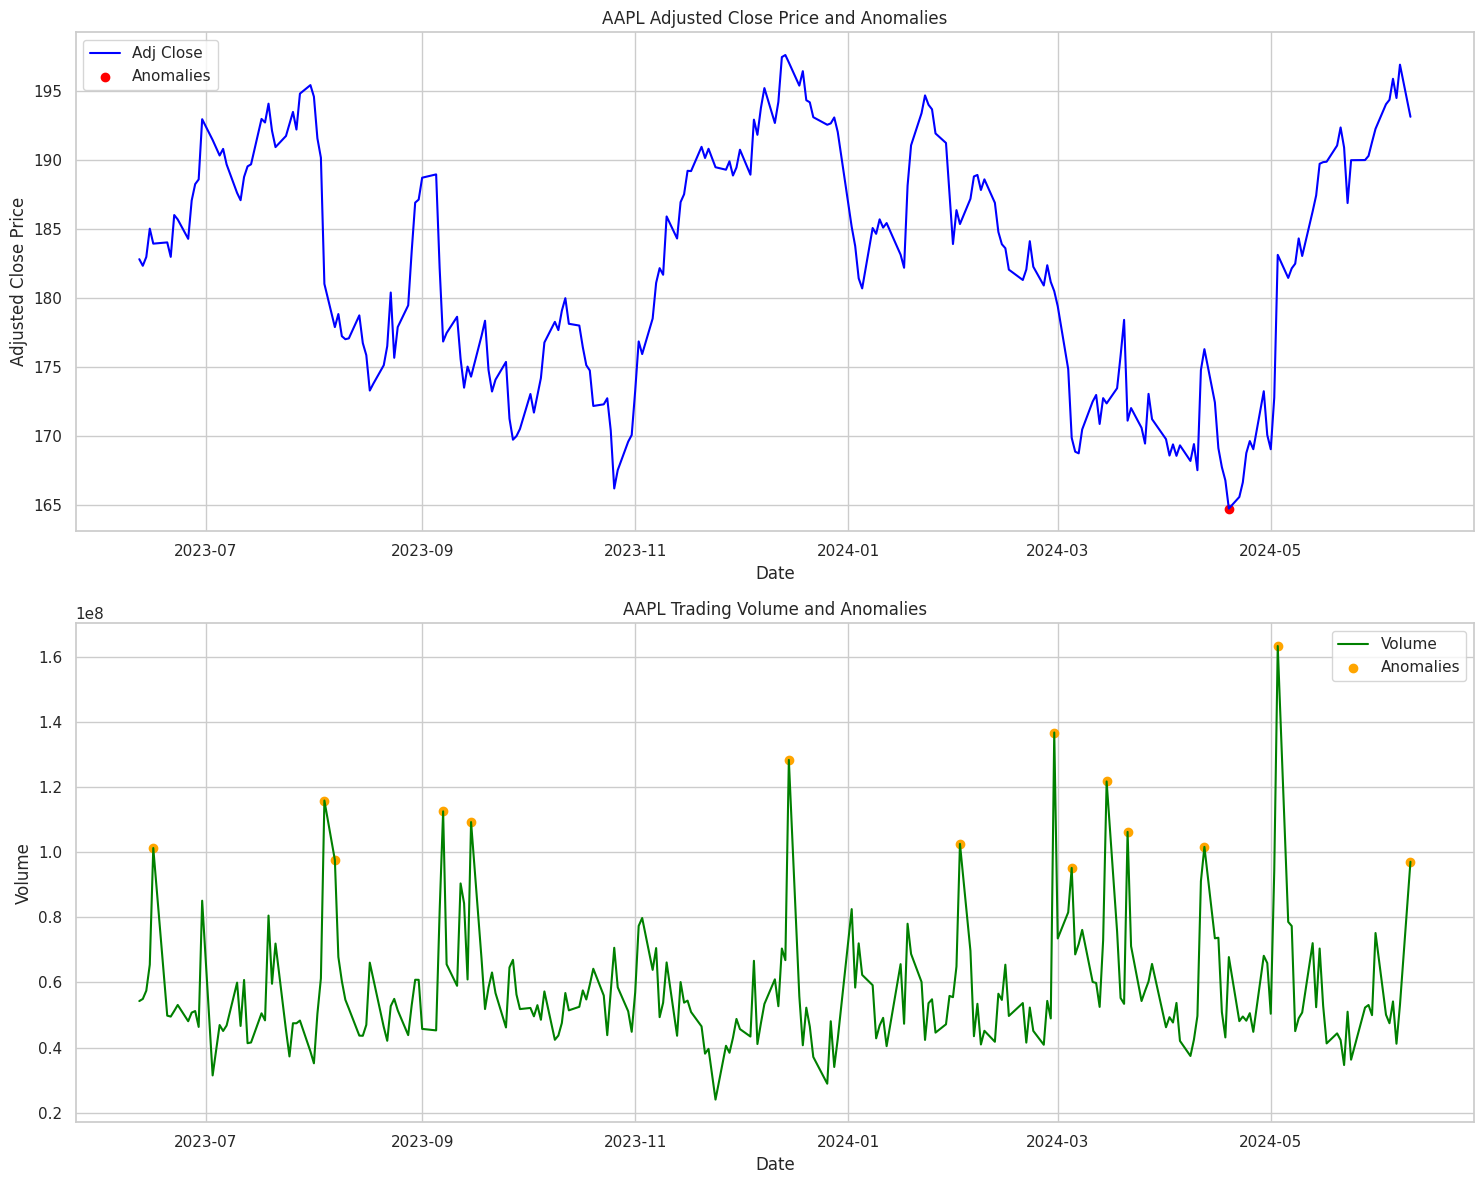

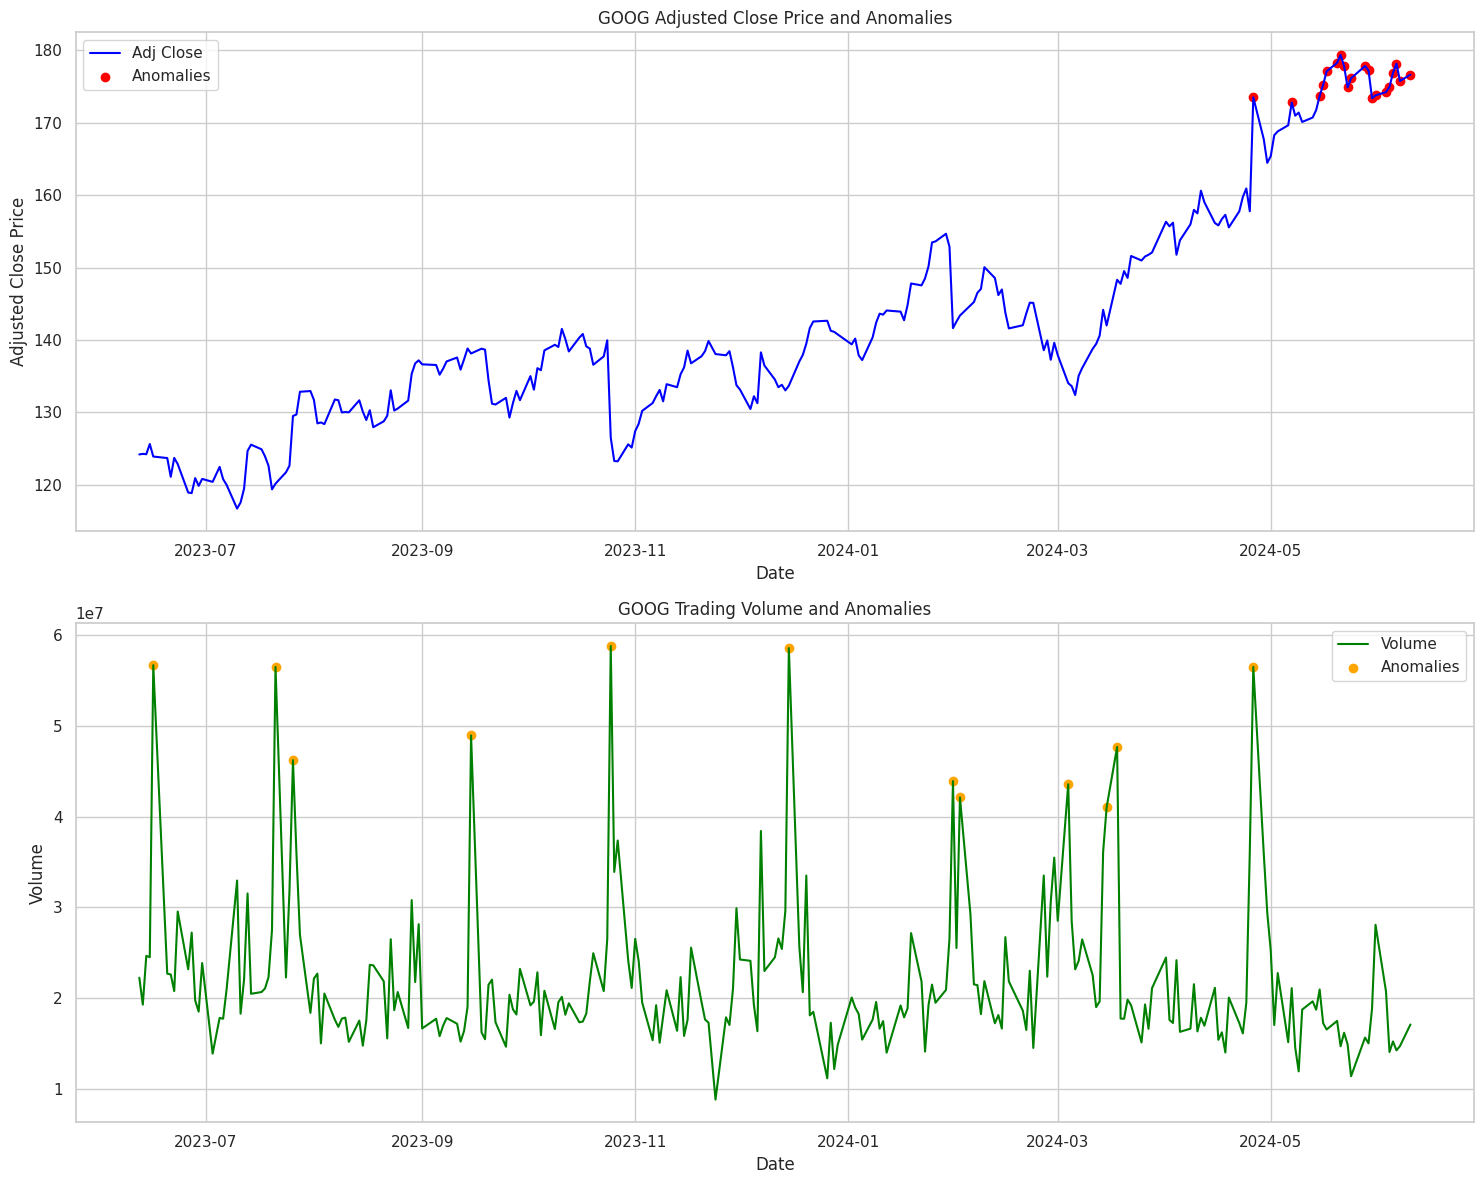

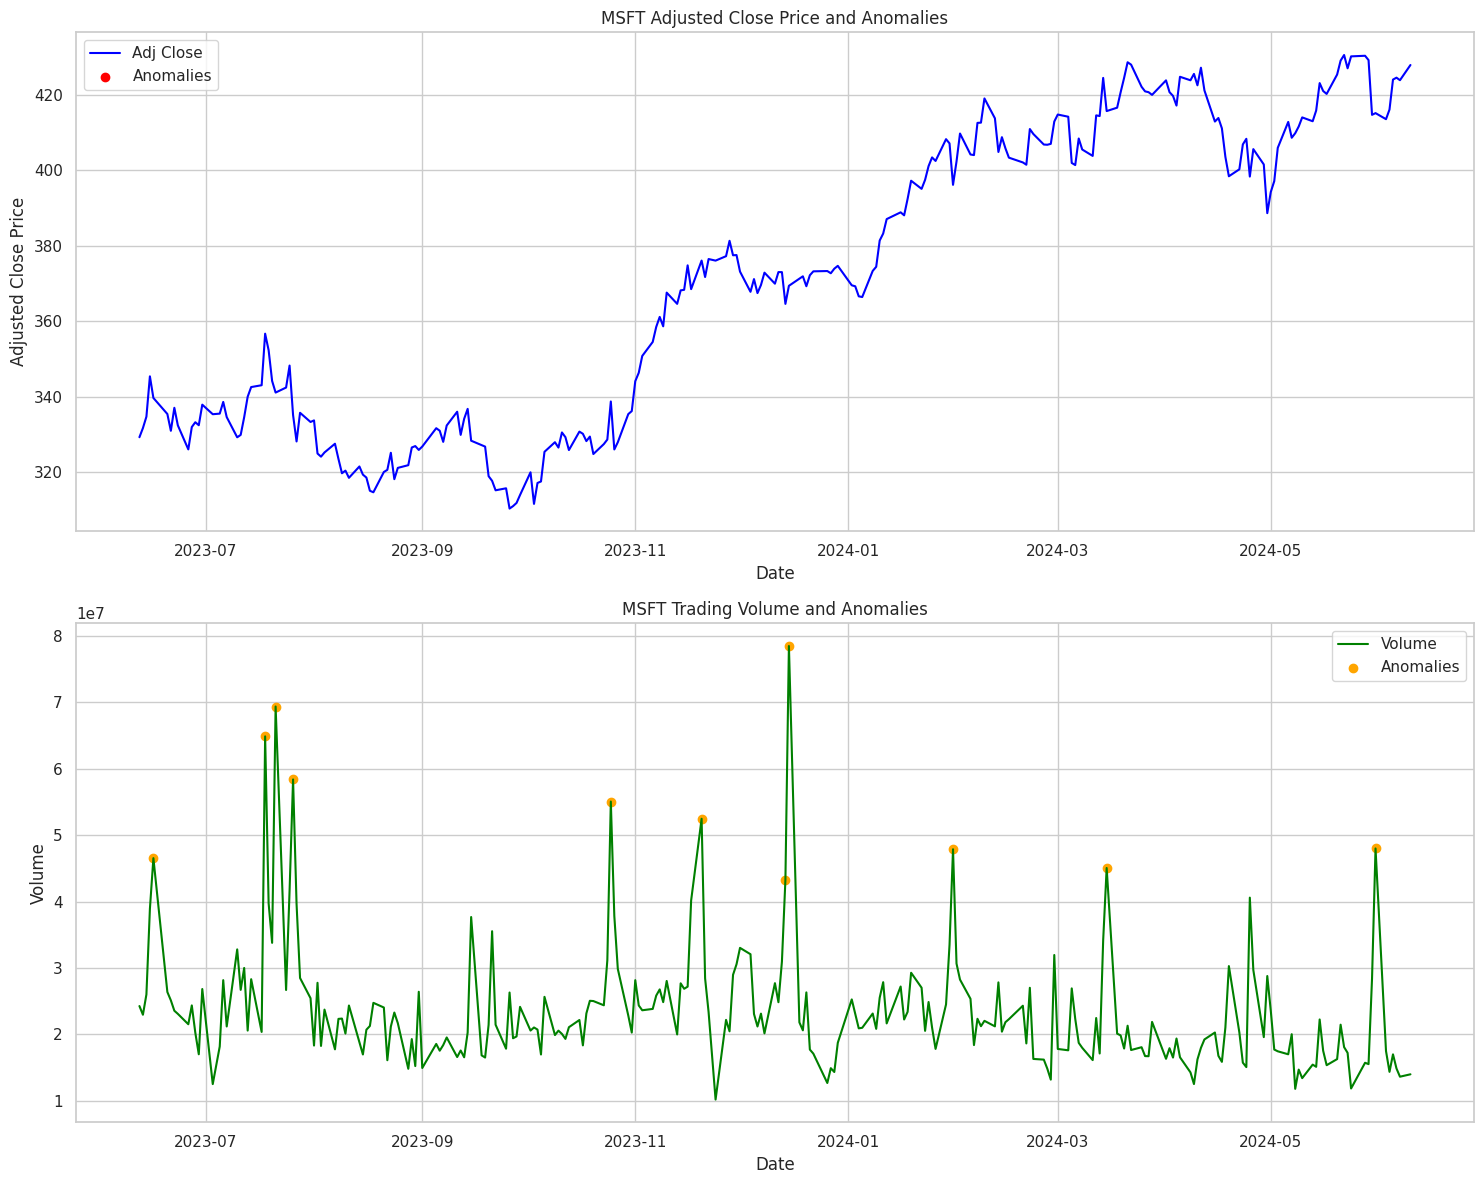

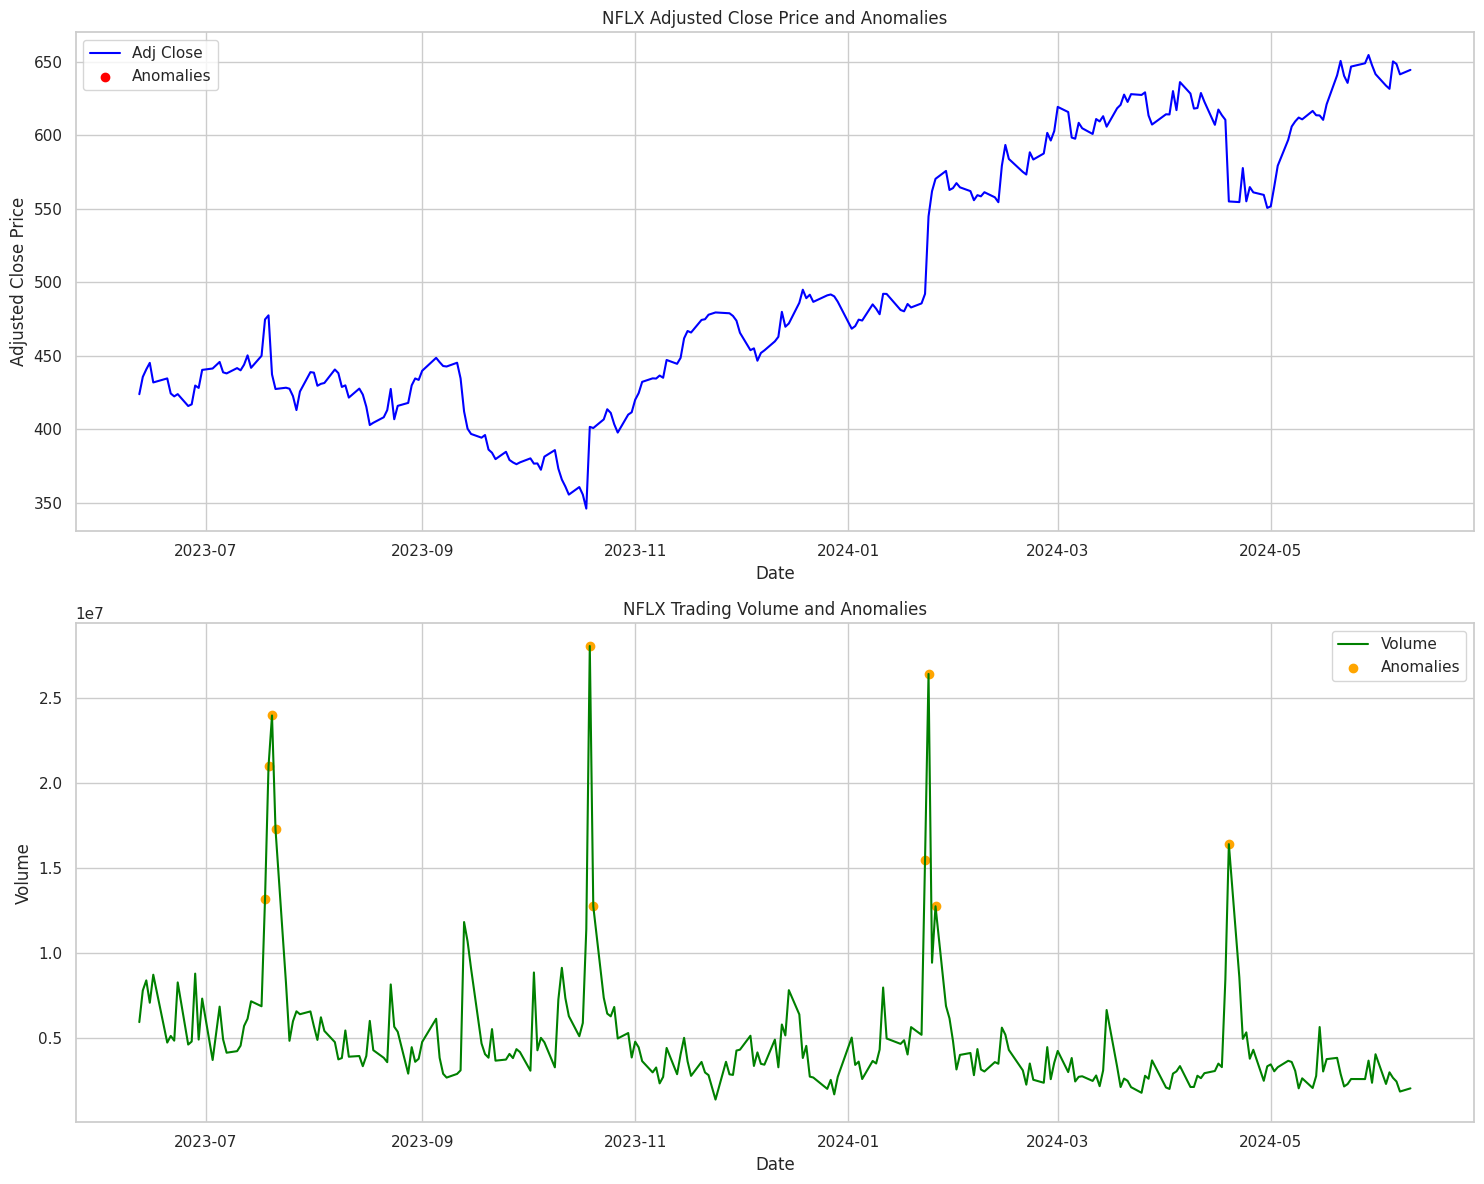

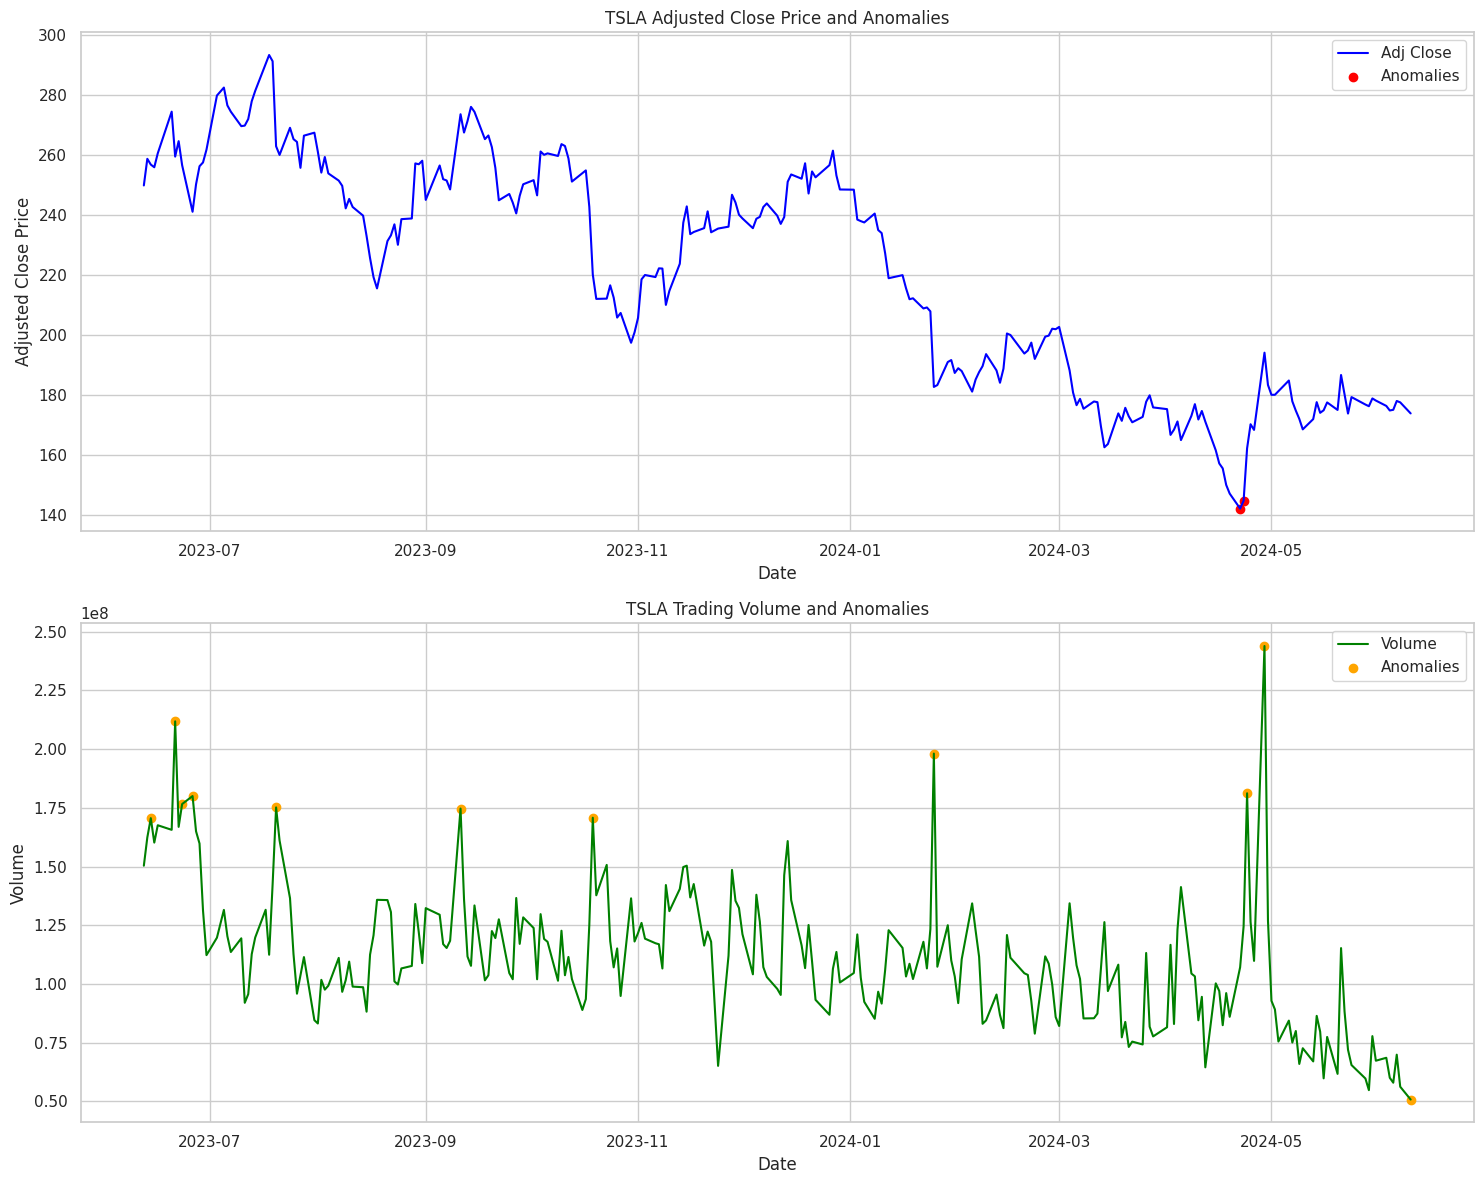

In [13]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [14]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                         Adj Close Anomaly                     Volume Anomaly  \
Ticker                                AAPL      GOOG      TSLA           AAPL   
                  Ticker                                                        
Adj Close Anomaly AAPL            1.000000 -0.550482 -0.065795      -0.333333   
                  GOOG           -0.550482  1.000000 -0.796819       0.333333   
                  TSLA           -0.065795 -0.796819  1.000000            NaN   
Volume Anomaly    AAPL           -0.333333  0.333333       NaN       1.000000   
                  GOOG           -0.333333  0.333333       NaN       0.102016   
                  MSFT           -0.333333  0.333333       NaN      -0.087773   
                  NFLX            1.000000 -1.000000       NaN      -0.408979   
                  TSLA           -0.333333  0.333333       NaN      -0.319945   

                                                                  
Ticker                        GOOG      M

In [15]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
AAPL    0.371936
GOOG    1.000000
MSFT         NaN
NFLX         NaN
TSLA    0.000000
Name: Z-score, dtype: float64
